In [1]:
from __future__ import print_function
from csky.ipyconfig import *
from csky import bk, analysis, coord, dists, hyp, inj, llh, pdf, selections, trial, utils
import histlite as hl
import healpy as hp
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from icecube import astro

mp_cpus = 15

In [2]:
ana_dir = utils.ensure_dir ('/data/user/drysewyk/csky_cache/ana')
repo = selections.mrichman_repo

In [3]:
ana7 = analysis.Analysis (repo, selections.PSDataSpecs.ps_7yr, dir=ana_dir)

Setting up Analysis for:
IC40, IC59, IC79, IC86_2011, IC86_2012_2014
Setting up IC40...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC40_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC40_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana/IC40.subanalysis.npy    
Setting up IC59...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC59_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC59_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana/IC59.subanalysis.npy    
Setting up IC79...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC79_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC79_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana/IC79.subanalysis.npy    
Setting up IC86_2011...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC86_2011_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC86_2011_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana/I

In [1]:
def get_llh (a, src):
    # space PDF - use default background space PDF and signal acceptance parameterization
    space_model = pdf.PointSourceSpacePDFRatioModel ( a, src, a.bg_space_param, a.acc_param )
    # energy PDF - use default parameterization
    energy_model = a.energy_pdf_ratio_model
    # put it together
    pdf_ratio_model = pdf.MultiPDFRatioModel (space_model, energy_model)
    N = len (a.data)
    llh_model = llh.LLHModel (pdf_ratio_model, N)
    return llh_model

def get_injs (a, llh_model, src, flux, cut_n_sigma, inj):
    # note which event features we need
    keep = llh_model.pdf_ratio_model.keep
    # optimization: dec band cut
    selector = cy.inj.DecBandSelector (src, cut_n_sigma=cut_n_sigma)
    # truth: unscrambled data, for unblinding
    truth = cy.inj.DataInjector (a, selector (a.data), keep, randomizers=[])
    # bg: scrambled data
    randomizers = [cy.inj.RARandomizer ()]#, cy.inj.DecRandomizer()]#, cy.inj.PoleRandomizer (np.radians (30))]
    bg = cy.inj.DataInjector (a, selector (a.data), keep, randomizers=randomizers)
    # sig: signal injection
    sig = cy.inj.PointSourceInjector (a, src, flux, keep) if inj else None
    return truth, bg, sig

def get_tr (src, ana=ana7, flux=hyp.PowerLawFlux (2), inj=True, use_energy=True, cut_n_sigma=5, sigsub=False, _fit_null=True, mp_cpus=mp_cpus):
    # get_llh needs the src list
    llh_kw = dict (src=src)
    # get_injs needs the src list and signal spectrum
    inj_kw = dict (src=src, flux=flux, cut_n_sigma=cut_n_sigma, inj=inj)
    # trial.get_trial_runner loops over sub analyses and gives a single TrialRunner
    return trial.get_trial_runner (
        ana, get_llh, get_injs, llh_kw=llh_kw, inj_kw=inj_kw, mp_cpus=mp_cpus)


def get_getters (ana=ana7, extension=0, cut_n_sigma=3, sigsub=False):
    def get_tr_skymap (src=None, cut_n_sigma=3, _fit_null=True, inj=True):
        if src is None:
            src = utils.Sources (ra=0, dec=0, extension=extension)
        src['extension'] = extension * np.ones_like (src.dec)
        return get_tr (src, ana=ana, cut_n_sigma=cut_n_sigma, sigsub=sigsub, _fit_null=_fit_null, inj=inj)
    def get_selector (dec):
        return inj.DecBandSelector (utils.Sources (dec=dec, extension=extension))
    return get_tr_skymap, get_selector

def plot_result (v, clabel, title='', vmin=None, vmax=None, cmap='viridis', projection='aitoff'):
    if vmin is None:
        vmin = 0
    if vmax is None:
        vmax = np.ceil (v.max())
    fig, ax = plt.subplots (figsize=(8,6), subplot_kw=dict (projection=projection))
    sp = csp.SkyPlotter (pc_kw=dict (cmap=cmap, vmin=vmin, vmax=vmax))
    v = hp.ud_grade (v, 256)
    mesh, cb = sp.plot_map (ax, v, n_ticks=2, titleticks=bool (title))
    sp.plot_gp (ax, color='.5', lw=.5, alpha=.25)
    ax.grid (alpha=.5, ls='-')
    cb.set_label (clabel)
    ax.set_title (title)
    plt.tight_layout()
    return fig, ax

NameError: name 'ana7' is not defined

In [25]:
sr_tracks = trial.SkyScanner (*get_getters(ana=ana7,extension=np.radians(0)), mp_cpus=mp_cpus)

scan_ra_tr, scan_dec_tr = sr_tracks.get_healpix_grid (nside=64)
#scan_l_tr, scan_b_tr = astro.equa_to_gal (scan_ra_tr, scan_dec_tr)
#mask_tr = (np.abs (scan_b_tr) < np.radians (10))
%time scan_ra_tr, scan_dec_tr, scan_tr = sr_tracks.get_one_scan(scan_ra_tr, scan_dec_tr, TRUTH=False) #, mask=mask_tr)

Scanning 49152 locations using 15 cores:
      49152/49152 coordinates complete.   
CPU times: user 1.63 s, sys: 1.31 s, total: 2.94 s
Wall time: 5min 30s


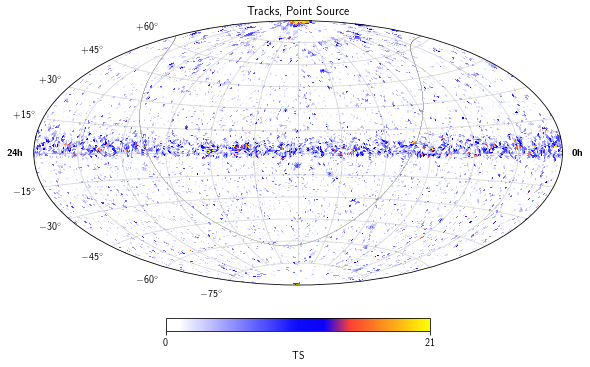

In [26]:
plot_result (scan_tr[0], r'TS', title=r'Tracks, Point Source',
             projection='aitoff', cmap=csp.skymap_cmap, vmax=21);

In [27]:
sr_tracks_1 = trial.SkyScanner (*get_getters(ana=ana7,extension=np.radians(1)), mp_cpus=mp_cpus)

scan_ra_tr_1, scan_dec_tr_1 = sr_tracks_1.get_healpix_grid (nside=64)
#scan_l_tr_1, scan_b_tr_1 = astro.equa_to_gal (scan_ra_tr_1, scan_dec_tr_1)
#mask_tr_1 = (np.abs (scan_b_tr_1) < np.radians (10))
%time scan_ra_tr_1, scan_dec_tr_1, scan_tr_1 = sr_tracks_1.get_one_scan(scan_ra_tr_1, scan_dec_tr_1, TRUTH=False) #, mask=mask_tr_1)

Scanning 49152 locations using 15 cores:
      49152/49152 coordinates complete.   
CPU times: user 1.87 s, sys: 1.39 s, total: 3.26 s
Wall time: 8min 26s


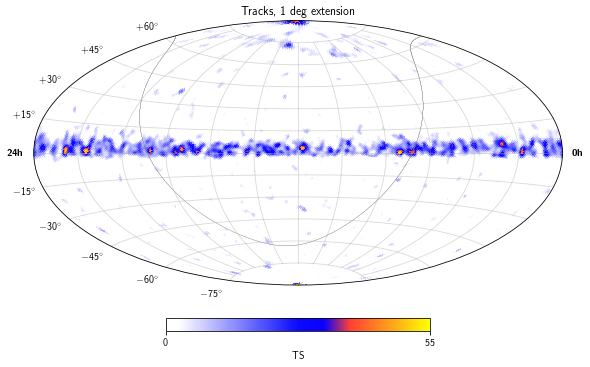

In [28]:
plot_result (scan_tr_1[0], r'TS', title=r'Tracks, 1 deg extension',
             projection='aitoff', cmap=csp.skymap_cmap);

In [29]:
sr_tracks_2 = trial.SkyScanner (*get_getters(ana=ana7,extension=np.radians(2)), mp_cpus=mp_cpus)

scan_ra_tr_2, scan_dec_tr_2 = sr_tracks_2.get_healpix_grid (nside=64)
#scan_l_tr_2, scan_b_tr_2 = astro.equa_to_gal (scan_ra_tr_2, scan_dec_tr_2)
#mask_tr_2 = (np.abs (scan_b_tr_2) < np.radians (10))
%time scan_ra_tr_2, scan_dec_tr_2, scan_tr_2 = sr_tracks_2.get_one_scan(scan_ra_tr_2, scan_dec_tr_2, TRUTH=True) #, mask=mask_tr_2)

Scanning 49152 locations using 15 cores:
      49152/49152 coordinates complete.   
CPU times: user 2.28 s, sys: 1.31 s, total: 3.59 s
Wall time: 12min 16s


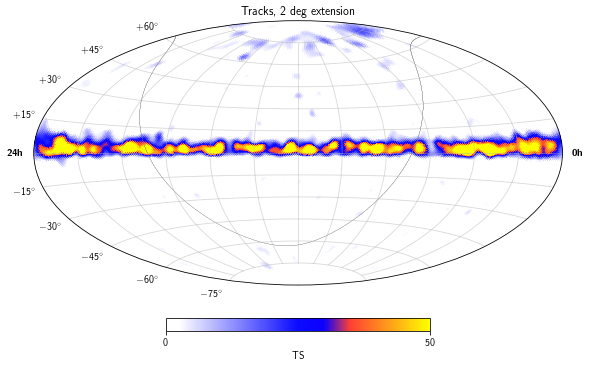

In [30]:
plot_result (scan_tr_2[0], r'TS', title=r'Tracks, 2 deg extension',
             projection='aitoff', cmap=csp.skymap_cmap, vmax=50);

In [31]:
sr_tracks_3 = trial.SkyScanner (*get_getters(ana=ana7,extension=np.radians(3)), mp_cpus=mp_cpus)

scan_ra_tr_3, scan_dec_tr_3 = sr_tracks_3.get_healpix_grid (nside=64)
#scan_l_tr_3, scan_b_tr_3 = astro.equa_to_gal (scan_ra_tr_3, scan_dec_tr_3)
#mask_tr_3 = (np.abs (scan_b_tr_3) < np.radians (10))
%time scan_ra_tr_3, scan_dec_tr_3, scan_tr_3 = sr_tracks_3.get_one_scan(scan_ra_tr_3, scan_dec_tr_3, TRUTH=False) #, mask=mask_tr_3)

Scanning 49152 locations using 15 cores:
      49152/49152 coordinates complete.   
CPU times: user 3 s, sys: 1.3 s, total: 4.3 s
Wall time: 17min 17s


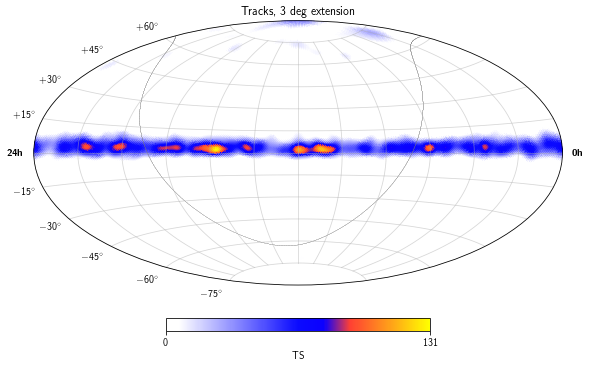

In [20]:
plot_result (scan_tr_3[0], r'TS', title=r'Tracks, 3 deg extension',
             projection='aitoff', cmap=csp.skymap_cmap);

In [19]:
sr_tracks_4 = trial.SkyScanner (*get_getters(ana=ana7,extension=np.radians(4)), mp_cpus=mp_cpus)

scan_ra_tr_4, scan_dec_tr_4 = sr_tracks_4.get_healpix_grid (nside=64)
#scan_l_tr_4, scan_b_tr_4 = astro.equa_to_gal (scan_ra_tr_4, scan_dec_tr_4)
#mask_tr_4 = (np.abs (scan_b_tr_4) < np.radians (10))
%time scan_ra_tr_4, scan_dec_tr_4, scan_tr_4 = sr_tracks_4.get_one_scan(scan_ra_tr_4, scan_dec_tr_4, TRUTH=False) #, mask=mask_tr_4)

Scanning 49152 locations using 15 cores:
      49152/49152 coordinates complete.   
CPU times: user 3.77 s, sys: 1.74 s, total: 5.51 s
Wall time: 23min 18s


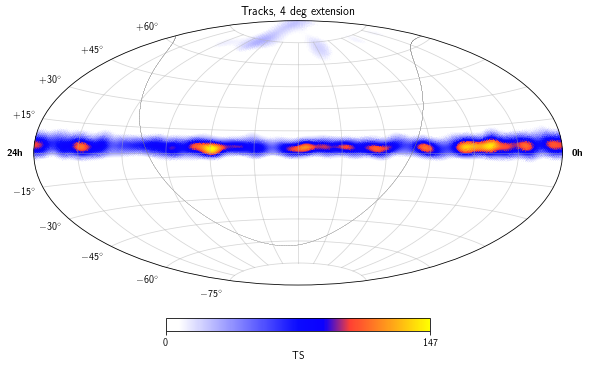

In [21]:
plot_result (scan_tr_4[0], r'TS', title=r'Tracks, 4 deg extension',
             projection='aitoff', cmap=csp.skymap_cmap);

In [22]:
sr_tracks_5 = trial.SkyScanner (*get_getters(ana=ana7,extension=np.radians(5)), mp_cpus=mp_cpus)

scan_ra_tr_5, scan_dec_tr_5 = sr_tracks_5.get_healpix_grid (nside=64)
#scan_l_tr_5, scan_b_tr_5 = astro.equa_to_gal (scan_ra_tr_5, scan_dec_tr_5)
#mask_tr_5 = (np.abs (scan_b_tr_5) < np.radians (10))
%time scan_ra_tr_5, scan_dec_tr_5, scan_tr_5 = sr_tracks_5.get_one_scan(scan_ra_tr_5, scan_dec_tr_5, TRUTH=False) #, mask=mask_tr_5)

Scanning 49152 locations using 15 cores:
      49152/49152 coordinates complete.   
CPU times: user 4.51 s, sys: 1.5 s, total: 6.01 s
Wall time: 31min 8s


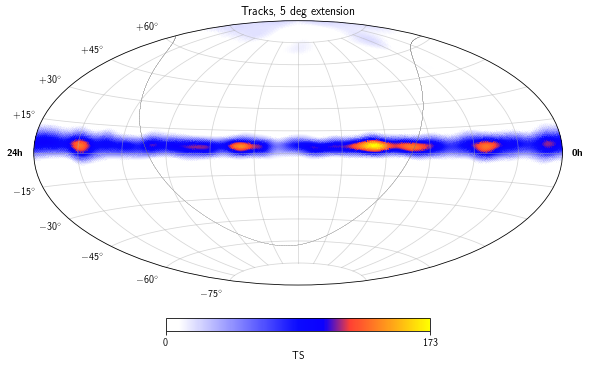

In [24]:
plot_result (scan_tr_5[0], r'TS', title=r'Tracks, 5 deg extension',
             projection='aitoff', cmap=csp.skymap_cmap);